### Warning: This code is just to explain the topic Cycle gan, I did not fine tune the parameters or trained for long hours, and i used the earlier to pix2pix networks for generator and discriminator, not recommended to use for this code for different problems ( or if you use it feel free to change the model and let us know)

In [1]:
import random
import matplotlib.pyplot as plt
import os, time,itertools, imageio, pickle
import tensorflow as tf
import numpy as np

In [2]:
learning_rate = 0.01
img_size = 256
channels = 3
batch_size = 16

In [3]:
# reading the data

trainA_path = "horse2zebra/trainA/"
trainB_path = "horse2zebra/trainB/"

trainA_files = os.listdir(trainA_path)
trainB_files = os.listdir(trainB_path)

trainA,trainB = [], []

for file in trainA_files:
    trainA.append(plt.imread(trainA_path+file))
for file in trainB_files:
    img = plt.imread(trainB_path+file)
    if img.shape!= (256,256,3):
        continue
    trainB.append(img)

trainA, trainB = np.array(trainA), np.array(trainB)
trainB = trainB[:len(trainA)]

print(trainA.shape,trainB.shape)


(1067, 256, 256, 3) (1067, 256, 256, 3)


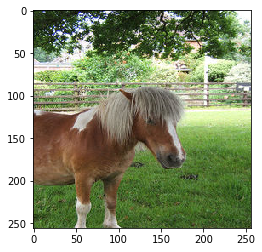

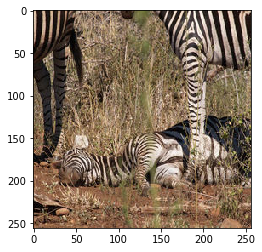

In [4]:
plt.imshow(trainA[4])
plt.show()
plt.imshow(trainB[4])
plt.show()

In [5]:
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, channels), name ="x")
y = tf.placeholder(tf.float32, shape=(None, img_size, img_size, channels), name ="y")

In [6]:
def lrelu(X, leak=0.3):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
b_init = tf.constant_initializer(1.0)

def generator(x, isTrain=True, reuse=False,scope=None):
    
    with tf.variable_scope(scope, reuse=reuse):

        # encoder
        conv1 = lrelu(tf.layers.conv2d(x, 64, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init))
        conv2 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv1, 128, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv3 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv2, 256, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv4 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv3, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv5 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv4, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv6 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv5, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv7 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv6, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv8 = tf.nn.relu(tf.layers.conv2d(conv7, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init))

        # decoder and skip connections
        deconv1 = tf.nn.dropout(tf.layers.batch_normalization(tf.layers.conv2d_transpose(conv8, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain), keep_prob=0.5)
        deconv1 = tf.nn.relu(tf.concat([deconv1, conv7], 3))
        
        deconv2 = tf.nn.dropout(tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv1, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain), keep_prob=0.5)
        deconv2 = tf.nn.relu(tf.concat([deconv2, conv6], 3))
        
        deconv3 = tf.nn.dropout(tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv2, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain), keep_prob=0.5)
        deconv3 = tf.nn.relu(tf.concat([deconv3, conv5], 3))
        
        deconv4 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv3, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        deconv4 = tf.nn.relu(tf.concat([deconv4, conv4], 3))
        
        deconv5 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv4, 256, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        deconv5 = tf.nn.relu(tf.concat([deconv5, conv3], 3))
        
        deconv6 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv5, 128, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        deconv6 = tf.nn.relu(tf.concat([deconv6, conv2], 3))
        
        deconv7 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv6, 64, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        deconv7 = tf.nn.relu(tf.concat([deconv7, conv1], 3))
        
        deconv8 = tf.nn.tanh(tf.layers.conv2d_transpose(deconv7, 3, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init))

        return deconv8

def discriminator(x, isTrain=True, reuse=False,scope=None):
    
    with tf.variable_scope(scope, reuse=reuse):
        
        conv1 = lrelu(tf.layers.conv2d(x, 64, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init))
        conv2 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv1, 128, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        
        conv3 = tf.layers.batch_normalization(tf.layers.conv2d(conv2, 256, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        conv3 = lrelu(tf.pad(conv3, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT"))
        
        conv4 = tf.layers.batch_normalization(tf.layers.conv2d(conv3, 512, [4, 4], strides=(1, 1), padding='valid', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        conv4 = lrelu(tf.pad(conv4, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT"))
        
        conv5 = tf.layers.conv2d(conv4, 1, [4, 4], strides=(1, 1), padding='valid', kernel_initializer=w_init, bias_initializer=b_init)
        
        out = tf.nn.sigmoid(conv5) #gives 30*30 patchGAN

        return out, conv5

In [7]:
y_fake = generator(x,scope='G_x2y') # x --> G(x) --> y'
x_fake = generator(y, scope='G_y2x') # y --> F(y) --> x'


#should be getting same as x and y
x_cycle = generator(y_fake,reuse=True,scope='G_y2x') # x --> G(x) --> y' --> F(y') = x
y_cycle = generator(x_fake,reuse=True,scope='G_x2y') # y --> F(y) --> x' --> G(x') = y

In [8]:
DX_real = discriminator(x,scope='DX')
DY_real = discriminator(y,scope='DY')
DX_fake = discriminator(x_fake, reuse=True,scope='DX')
DY_fake = discriminator(y_fake, reuse=True,scope='DY')

In [9]:
# Discriminator loss (we use LSGAN loss) 
Gan_loss_DX = (tf.reduce_mean(tf.square(DX_real - tf.ones_like(DX_real))) + 
               tf.reduce_mean(tf.square(DX_fake)))/ 2.0
Gan_loss_DY = (tf.reduce_mean(tf.square(DY_real - tf.ones_like(DY_real))) + 
               tf.reduce_mean(tf.square(DY_fake))) / 2.0

In [10]:
# Cycle consistent loss
l1 = 10
cycle_loss = tf.reduce_mean(l1 * tf.abs(x - x_cycle)) + tf.reduce_mean(l1 * tf.abs(y - y_cycle)) 

In [11]:
# Generator loss
Gan_loss_GX = tf.reduce_mean(tf.square(DY_fake - tf.ones_like(DY_fake))) + cycle_loss
Gan_loss_FY = tf.reduce_mean(tf.square(DX_fake - tf.ones_like(DX_fake))) + cycle_loss

In [12]:
DX_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DX')
DY_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DY')
G_x2y_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'G_x2y')
G_y2x_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'G_y2x')

In [13]:
DX_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Gan_loss_DX, var_list=DX_vars)
DY_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Gan_loss_DY, var_list=DY_vars)
G_x2y_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Gan_loss_GX, var_list=G_x2y_vars)
G_y2x_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Gan_loss_FY, var_list=G_y2x_vars)

In [14]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [15]:
X_test = trainA[:16]
Y_test = trainB[:16]

def show_result(num_epoch,y_f,test_AB):
    
    if y_f:
        test_images = sess.run(y_fake, {x: test_AB})
    else:
        test_images = sess.run(x_fake, {y: test_AB})


    size_figure_grid = 4
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4, 4))
    
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    
    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        a = np.reshape(test_images[k], (256, 256, 3))*255
        ax[i, j].imshow(a.astype(np.uint8))

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    plt.show()

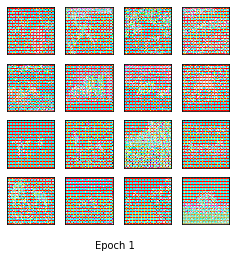

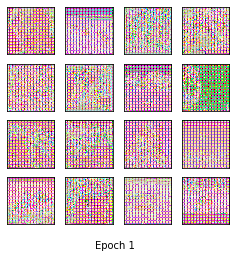

In [16]:
show_result(1,True,X_test)
show_result(1,False,Y_test)

In [ ]:
for it in range(20):
    
    epoch_start_time = time.time()
        
    for iter in range(len(trainA) // batch_size):
                
        X = trainA[iter*batch_size:(iter+1)*batch_size]
        Y = trainB[iter*batch_size:(iter+1)*batch_size]

        X_fake, Y_fake = sess.run([x_fake,y_fake],feed_dict={x: X,y: Y})

        # Optimize G Networks
        loss_G_x2y,_ = sess.run([Gan_loss_GX,G_x2y_solver], feed_dict={x:X,y:Y})
        loss_G_y2x,_ = sess.run([Gan_loss_FY,G_y2x_solver], feed_dict={x:X,y:Y})

        # Optimize D Networks
        loss_DY,_ = sess.run([Gan_loss_DY,DY_solver],feed_dict={x: X,y: Y})
        loss_DX,_ = sess.run([Gan_loss_DX,DX_solver],feed_dict={x: X,y: Y})

    if it % 1 == 0:

        show_result((it + 1),True,X_test)
        show_result((it + 1),False,Y_test)

        print()
        print("Gan_loss_DX, Gan_loss_DY, Gan_loss_GX, Gan_loss_FY",loss_DX,loss_DX,loss_G_x2y,loss_G_y2x)
            
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("The total time for epoch{0} is{1} ".format(it,per_epoch_ptime))

In [ ]:
#Taking hige amount of CPU time for an epoch so... 